# Lecture 5: Simulation of Kolmogorov Flow

In [1]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import Image

from IPython.core.display import HTML
def header(text):
    raw_html = '<h4>' + str(text) + '</h4>'
    return raw_html

def box(text):
    raw_html = '<div style="border:1px dotted black;padding:2em;">'+str(text)+'</div>'
    return HTML(raw_html)

def nobox(text):
    raw_html = '<p>'+str(text)+'</p>'
    return HTML(raw_html)

def addContent(raw_html):
    global htmlContent
    htmlContent += raw_html
    
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 18,
        }



<p class='alert alert-success'>
Solve the questions in green blocks. Save the file as ME249-Lecture-5-YOURNAME.ipynb and change YOURNAME in the bottom cell. Send the instructor and the grader the <b>html</b> file not the ipynb file. 
</p>

## Basic Functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np



def flux_computation(u,v,p,dx,dy,nu):
    nx = u.shape[0]
    ny = u.shape[1]
    
    f_xx = np.zeros((nx,ny),dtype='float64')
    f_xx[0:nx-1,:] = -0.25*(u[1:nx,:]+u[0:nx-1,:])*(u[1:nx,:]+u[0:nx-1,:]) \
                     +2.*nu*(u[1:nx,:]-u[0:nx-1,:])/dx
    f_xx[nx-1,:] = -0.25*(u[0,:]+u[nx-1,:])*(u[0,:]+u[nx-1,:]) \
                   + 2.*nu*(u[0,:]-u[nx-1,:])/dx
    
    f_xy = np.zeros((nx,ny),dtype='float64')
    f_xy[0:nx-1,0:ny-1] = -0.25*(u[0:nx-1,0:ny-1]+u[0:nx-1,1:ny]) \
                               *(v[0:nx-1,0:ny-1]+v[1:nx,0:ny-1]) \
                          +nu*((u[0:nx-1,1:ny]-u[0:nx-1,0:ny-1])/dy\
                              +(v[1:nx,0:ny-1]-v[0:nx-1,0:ny-1])/dx)
    f_xy[nx-1,0:ny-1] = -0.25*(u[nx-1,0:ny-1]+u[nx-1,1:ny]) \
                               *(v[nx-1,0:ny-1]+v[0,0:ny-1]) \
                          +nu*((u[nx-1,1:ny]-u[nx-1,0:ny-1])/dy\
                              +(v[0,0:ny-1]-v[nx-1,0:ny-1])/dx)
    f_xy[0:nx-1,ny-1] = -0.25*(u[0:nx-1,ny-1]+u[0:nx-1,0]) \
                               *(v[0:nx-1,ny-1]+v[1:nx,ny-1]) \
                          +nu*((u[0:nx-1,0]-u[0:nx-1,ny-1])/dy\
                              +(v[1:nx,ny-1]-v[0:nx-1,ny-1])/dx)
    f_xy[nx-1,ny-1] = -0.25*(u[nx-1,ny-1]+u[nx-1,0]) \
                               *(v[nx-1,ny-1]+v[0,ny-1]) \
                          +nu*((u[nx-1,0]-u[nx-1,ny-1])/dy\
                              +(v[0,ny-1]-v[nx-1,ny-1])/dx)
    f_yy = np.zeros((nx,ny),dtype='float64')
    f_yy[0:nx,0:ny-1] = -0.25*(v[0:nx,0:ny-1]+v[0:nx,1:ny]) \
                               *(v[0:nx,0:ny-1]+v[0:nx,1:ny]) \
                          +2.*nu*(v[0:nx,1:ny]-v[0:nx,0:ny-1])/dy
    f_yy[0:nx,ny-1] = -0.25*(v[0:nx,ny-1]+v[0:nx,0]) \
                               *(v[0:nx,ny-1]+v[0:nx,0]) \
                          +2.*nu*(v[0:nx,0]-v[0:nx,ny-1])/dy
    return f_xx,f_xy,f_yy



def divergence(f_x,f_y,dx,dy):
    nx = f_x.shape[0]
    ny = f_x.shape[1]
    div_x = np.zeros((nx,ny),dtype='float64')
    div_x[1:nx,:] = (f_x[1:nx,:] - f_x[0:nx-1,:])/dx
    div_x[0,:] = (f_x[0,:] - f_x[nx-1,:])/dx
    div_y = np.zeros((nx,ny),dtype='float64')
    div_y[:,1:ny] = (f_y[:,1:ny] - f_y[:,0:ny-1])/dy
    div_y[:,0] = (f_y[:,0] - f_y[:,ny-1])/dy
    return div_x+div_y



def Poisson_solver_fft(b,invmk2):
    b_hat = np.fft.fft2(b)
    b_hat *= invmk2
    b_hat[0,0] = 0.0 + 0.0j
    return np.real(np.fft.ifft2(b_hat))

def Laplacian_fft(b,mk2):
    b_hat = np.fft.fft2(b)
    b_hat *= mk2
    return np.real(np.fft.ifft2(b_hat))

def gradient_p(p,dx,dy):
    nx = p.shape[0]
    ny = p.shape[1]
    gradpx = np.zeros((nx,ny),dtype = 'float64')
    gradpy = np.zeros((nx,ny),dtype = 'float64')
    gradpx[0:nx-1,:] = (p[1:nx,:] - p[0:nx-1,:])/dx
    gradpx[nx-1,:] = (p[0,:] - p[nx-1,:])/dx
    gradpy[:,0:ny-1] = (p[:,1:ny] - p[:,0:ny-1])/dy
    gradpy[:,ny-1] = (p[:,0] - p[:,ny-1])/dy
    return gradpx,gradpy

<h2> Taylor-Green vortex</h2>

The Taylor-Green vortex is an analytical solution of the incompressible Navier Stokes equations derived for 2D periodic domains. The velocity components and pressure are defined as:
$$
u =f(t)\sin x\cos y\;, \\
v = -f(t)\cos x \sin y\;, \\
p = \frac{\rho}{4}f^2(t)(\cos 2x+\cos 2y)\;,
$$
respectively, and
$$
f(t)= e^{-2\nu t}
$$
In the following code, the density $rho$ is unity. 

The flow solver is 2<sup>nd</sup> order space, discretized on a staggered grid using central finite difference scheme. The time advancement scheme is the 2<sup>nd</sup> order Runge-Kutta scheme coupled with the fractional step.

<h3> Fractional step method</h3>

<ol>
<li> Advance the velocity field based on advection and viscous stresses only:
$$
u_i^* = u_i^n+\beta^k\Delta t\frac{\partial}{\partial x_j}\left[-u_i^nu_j^n+\nu\left(\frac{\partial u_i^n}{\partial x_j}+\frac{\partial u_j^n}{\partial x_i}\right)\right]
$$
</li>
<li> Calculate pseudo-pressure (pressure modulo a constant):
$$
\frac{\partial p^*}{\partial x_i\partial x_i}=\frac{1}{\beta^k\Delta t}\frac{\partial u^*_i}{\partial x_i}
$$
</li>
<li> Add the pressure gradient to the time advancement process (incompressibility step):
$$
u^{n+1}_i=u^*_i-\beta^k\frac{\partial p^*}{\partial x_i}
$$
</li>
</ol>
where $\beta^k$ is the Runga Kutta coefficient at step $k$. The second order Runge Kutta is defined as:
$$
u^{n+1/2}_i = u_i^n+\beta^0\Delta t(RHS)_i^n\\
u^{n+1}_i=u_i^n+\beta^1\Delta t(RHS)_i^{n+1/2}
$$
with $\beta^0=1/2$ and $\beta^1=1$. The fractional step is applied to both steps of the RK scheme.


In [4]:
#Taylor-Green Vortex Code
Lx = 2.*np.pi
Ly = 2.*np.pi

Nx = 32
Ny = 32

Reynolds = 10.
nu = 1./Reynolds

dt = 0.01

maxit = 1000

utrace = np.zeros(maxit)
ptrace = np.zeros(maxit)
ttrace = np.zeros(maxit)

dx = Lx / Nx
dy = Ly / Ny

# pressure, scalar node positions
x_n = np.linspace(+dx/2.,Lx-dx/2.,Nx)
y_n = np.linspace(+dy/2.,Ly-dy/2.,Ny)

# streamwise velocity node positions
x_u = np.linspace(+dx,Lx,Nx)
y_u = np.linspace(+dy/2.,Ly-dy/2.,Ny)

# normal velocity node positions
x_v = np.linspace(+dx/2.,Lx-dx/2.,Nx)
y_v = np.linspace(+dy,Ly,Ny)

# generation of the three grids of our staggered system
Yn,Xn = np.meshgrid(y_n,x_n)
Yu,Xu = np.meshgrid(y_u,x_u)
Yv,Xv = np.meshgrid(y_v,x_v)

# Initialisation of wavenumbers for Direct Poisson solver

kx = Nx*np.fft.fftfreq(Nx)
ky = Ny*np.fft.fftfreq(Ny)

kx2d = np.repeat(kx, Ny)
kx2d.shape = (Nx, Ny)

ky2d = np.repeat(ky, Nx)
ky2d.shape = (Ny, Nx)
ky2d = np.transpose(ky2d)

# -(kx^2+ky^2) using the second order scheme modified wavenumber
mk2 = 2.0*(np.cos(2.0*np.pi*kx2d/Nx)-1.0)/(dx*dx)\
        +2.0*(np.cos(2.0*np.pi*ky2d/Ny)-1.0)/(dy*dy)
invmk2  = 1./(mk2 + 1.e-20) #to avoid 1/0.

#allocation of memory
u = np.zeros((Nx,Ny),dtype='float64')
v = np.zeros((Nx,Ny),dtype='float64')
u_old = np.zeros((Nx,Ny),dtype='float64')
v_old = np.zeros((Nx,Ny),dtype='float64')
div = np.zeros((Nx,Ny),dtype='float64')
p = np.zeros((Nx,Ny),dtype='float64')

F_xx = np.zeros((Nx,Ny),dtype='float64')
F_xy = np.zeros((Nx,Ny),dtype='float64')
F_yy = np.zeros((Nx,Ny),dtype='float64')

# initialization (t=0)
u = np.sin(Xu) * np.cos(Yu)
v = -np.cos(Xv) * np.sin(Yv)
p = (np.cos(2.*Xn) + np.cos(2.*Yn))/4.
rhs_u = np.zeros((Nx,Ny))
rhs_v = np.zeros((Nx,Ny))

Nrk = 2
rk_coef = np.array([0.5 , 1.0])


for it in range(maxit):
    u_old = np.copy(u)
    v_old = np.copy(v)
    for irk in range(Nrk):
        F_xx,F_xy,F_yy = flux_computation(u,v,p,dx,dy,nu)
        rhs_u = divergence(F_xx,F_xy,dx,dy)
        rhs_v = divergence(F_xy,F_yy,dx,dy)
        
        #step 1
        u = u_old + rk_coef[irk]*dt*rhs_u
        v = v_old + rk_coef[irk]*dt*rhs_v
        
        #step 2
        div = divergence(u,v,dx,dy)

        div /= dt*rk_coef[irk]

        p = Poisson_solver_fft(div,invmk2)
        
        #step 3
        
        gradp_x, gradp_y = gradient_p(p,dx,dy)
        u -= dt*rk_coef[irk]*gradp_x
        v -= dt*rk_coef[irk]*gradp_y
    utrace[it] = u[Nx//2,Ny//2]
    ptrace[it] = p[Nx//2,Ny//2]
    ttrace[it] = dt*it
    div = divergence(u,v,dx,dy)
    err = np.max(np.abs(div))
    if (it % 250 == 0) : print('iteration: ',it,' divergence:',err)
print('iteration: ',it,' divergence:',err)


iteration:  0  divergence: 6.661338147750939e-16
iteration:  250  divergence: 4.510281037539698e-16
iteration:  500  divergence: 2.7755575615628914e-16
iteration:  750  divergence: 1.457167719820518e-16
iteration:  999  divergence: 1.3183898417423734e-16


<p class='alert alert-success'>
(a) Validate the code: Demonstrate that the flow solver's prediction at a time $t>0$ is an adequate representation of the analytical solution.
</p>

<p class='alert alert-success'>
(b) Run simulations for a duration of 10 adimensional time. Increase the time step to $\Delta t=0.1$ for $Nx=Ny=32$. What do you observe? Increase $N=128$ and find the appropriate time step? Frame your discussion in the context of the Courant Friedrich Levy (CFL) stability condition for the adection term:
$$
\Delta t\leq \cfrac{CFL}{\max_{i,j}\left[\cfrac{u_{i,j}}{\Delta x},\cfrac{v_{i,j}}{\Delta y}\right]}
$$
where $u_{i,j}$ and $v_{i,j}$ are the streamwise and normal velocity components at node $(i,j)$ of the $u$ and $v$ grids, respectively. You do not need to show code or results, just report your observations.
</p>

<p class='alert alert-success'>
(c) Modify the code to implement a dynamic time step procedure using the condition above. In theory, the 2<sup>nd</sup> RK scheme is stable for $CFL\leq\sqrt{2}$. Test this assertion.
</p>

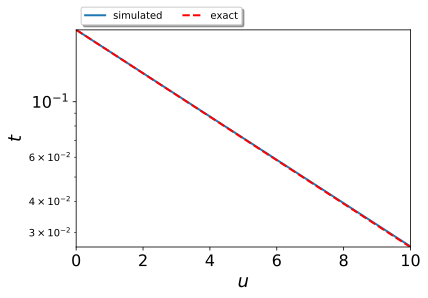

In [5]:
ftrace = np.exp(-2.*nu*ttrace)*utrace[0]
plt.semilogy(ttrace,utrace,lw=2,label='simulated')
plt.semilogy(ttrace,ftrace,'r--',lw=2,label='exact')
plt.xlim(0,10.)
plt.ylim(ftrace[maxit-1],ftrace[0])
plt.legend(loc=3, bbox_to_anchor=[0, 1],
           ncol=3, shadow=True, fancybox=True)
plt.xlabel('$u$', fontdict = font)
plt.ylabel('$t$', fontdict = font)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

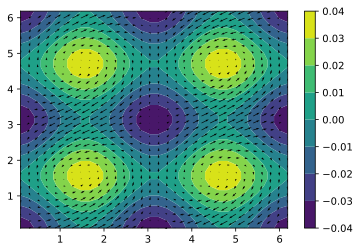

In [6]:
# Q criterion see paper
Q = Laplacian_fft(p,mk2)
plt.contourf(Xn,Yn,Q)
plt.colorbar()
Un = np.zeros((Nx,Ny),dtype='float64')
Vn = np.zeros((Nx,Ny),dtype='float64')
Un[1:Nx,:] = 0.5*(u[1:Nx,:]+u[0:Nx-1,:])
Un[0,:] = 0.5*(u[0,:]+u[Nx-1,:])
Vn[:,1:Ny] = 0.5*(v[:,1:Ny]+u[:,0:Ny-1])
Vn[:,0] = 0.5*(v[:,0]+u[:,Ny-1])
plt.quiver(Xn,Yn,Un,Vn)
plt.show

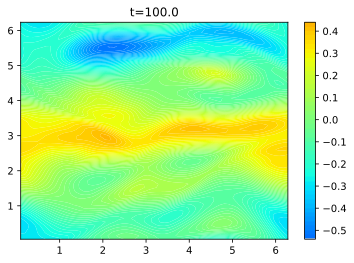

In [12]:
from IPython.display import clear_output
Lx = 2.*np.pi
Ly = 2.*np.pi

Nx = 64
Ny = 64

Reynolds = 1000.
nu = 1./Reynolds

dt = 0.01

maxit = 10000

utrace = np.zeros(maxit)
ttrace = np.zeros(maxit)

dx = Lx / Nx
dy = Ly / Ny

x_n = np.linspace(+dx/2.,Lx-dx/2.,Nx)
y_n = np.linspace(+dy/2.,Ly-dy/2.,Ny)

x_u = np.linspace(+dx,Lx,Nx)
y_u = np.linspace(+dy/2.,Ly-dy/2.,Ny)

x_v = np.linspace(+dx/2.,Lx-dx/2.,Nx)
y_v = np.linspace(+dy,Ly,Ny)

Yn,Xn = np.meshgrid(y_n,x_n)
Yu,Xu = np.meshgrid(y_u,x_u)
Yv,Xv = np.meshgrid(y_v,x_v)

# Initialisation of wavenumbers for Direct Poisson solver

kx = Nx*np.fft.fftfreq(Nx)
ky = Ny*np.fft.fftfreq(Ny)

kx2d = np.repeat(kx, Ny)
kx2d.shape = (Nx, Ny)

ky2d = np.repeat(ky, Nx)
ky2d.shape = (Ny, Nx)
ky2d = np.transpose(ky2d)

# -1./(kx^2+ky^2) using the second order scheme modified wavenumber
mk2  = 2.0*(np.cos(2.0*np.pi*kx2d/Nx)-1.0)/(dx*dx)\
        +2.0*(np.cos(2.0*np.pi*ky2d/Ny)-1.0)/(dy*dy)
    
invmk2  = 1./(2.0*(np.cos(2.0*np.pi*kx2d/Nx)-1.0)/(dx*dx)\
             +2.0*(np.cos(2.0*np.pi*ky2d/Ny)-1.0)/(dy*dy) + 1.e-20)

u = np.zeros((Nx,Ny),dtype='float64')
v = np.zeros((Nx,Ny),dtype='float64')
u_old = np.zeros((Nx,Ny),dtype='float64')
v_old = np.zeros((Nx,Ny),dtype='float64')
div = np.zeros((Nx,Ny),dtype='float64')
p = np.zeros((Nx,Ny),dtype='float64')

F_xx = np.zeros((Nx,Ny),dtype='float64')
F_xy = np.zeros((Nx,Ny),dtype='float64')
F_yy = np.zeros((Nx,Ny),dtype='float64')

# initialization

u += 0.*np.cos(4.*Yu) +0.1*(np.random.random((Nx,Ny)) -0.5)
v += 0.1*(np.random.random((Nx,Ny)) -0.5)
u += 0.1*np.sin(8*Xu) * np.cos(8*Yu)
v += -0.1*np.cos(8*Xv) * np.sin(8*Yv)
forcing = 16.*nu*np.cos(4.*Yu)
rhs_u = np.zeros((Nx,Ny))
rhs_v = np.zeros((Nx,Ny))

Nrk = 2
rk_coef = np.array([0.5 , 1.0])


for it in range(maxit):
    u_old = np.copy(u)
    v_old = np.copy(v)
    for irk in range(Nrk):
        F_xx,F_xy,F_yy = flux_computation(u,v,p,dx,dy,nu)
        rhs_u = divergence(F_xx,F_xy,dx,dy)
        rhs_v = divergence(F_xy,F_yy,dx,dy)
        
        
        u = u_old + rk_coef[irk]*dt*rhs_u
        v = v_old + rk_coef[irk]*dt*rhs_v
        
        div = divergence(u,v,dx,dy)

        div /= dt*rk_coef[irk]

        p = Poisson_solver_fft(div,invmk2)
        
        gradp_x, gradp_y = gradient_p(p,dx,dy)
        u -= dt*rk_coef[irk]*(gradp_x-forcing)
        v -= dt*rk_coef[irk]*gradp_y
        
        #u -= dt*np.cos(2*Yu)
        
        div = divergence(u,v,dx,dy)
        #if (it % 200 == 0) : print(np.max(np.abs(div)))
    utrace[it] = u[Nx//2,Ny//2]
    ttrace[it] = dt*(it+1)
    if ((it+1)%100 == 0):
        cmap = plt.cm.jet
        plt.contourf(Xu,Yu,u,50,cmap=cmap,vmin=-1,vmax=+1)
        plt.title('t='+str(ttrace[it]))
        plt.clim(-1.,1.)
        plt.colorbar()
        plt.show()
        clear_output(wait=True)
        


<function matplotlib.pyplot.show(*args, **kw)>

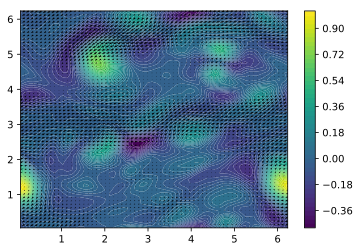

In [13]:
Q = Laplacian_fft(p,mk2)
plt.contourf(Xn,Yn,Q,50)
plt.colorbar()
Un = np.zeros((Nx,Ny),dtype='float64')
Vn = np.zeros((Nx,Ny),dtype='float64')
Un[1:Nx,:] = 0.5*(u[1:Nx,:]+u[0:Nx-1,:])
Un[0,:] = 0.5*(u[0,:]+u[Nx-1,:])
Vn[:,1:Ny] = 0.5*(v[:,1:Ny]+u[:,0:Ny-1])
Vn[:,0] = 0.5*(v[:,0]+u[:,Ny-1])
plt.quiver(Xn,Yn,Un,Vn)
plt.show

<p class='alert alert-success'>
(d) Modify the code to implement a dynamic time step procedure using the CFL condition and have the code stop at a prescribed time $T_\max=100$. Use $CFL=1$.
</p>

<p class='alert alert-success'>
(e) Run the code for $Nx=Ny=32$ and $Nx=Ny=64$ over 100 adimensional time. What do you observe in terms of velocity magnitude and vortex intensity? Discuss your observations based on Lecture 3.
</p>